<a href="https://colab.research.google.com/github/joeldmott/chicago_auto_accidents_project/blob/main/project_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Determining the Primary Causes of Traffic Accidents in Chicago

This projects raw dataset originates from the [City of Chicago's website](https://data.cityofchicago.org/Transportation/Traffic-Crashes-Crashes/85ca-t3if/about_data), where it is updated daily. I downloaded the data on May 1st, 2024 and [uploaded that snapshot to Kaggle](https://www.kaggle.com/datasets/joelmott/chicago-traffic-crashes-may-2024).

This dataset consists of three seperate csv files: one for general crash information, one for the people involved in each crash, and one for each vehicle. When merged, the resulting dataset contains over 150 columns and 3.8 million records. In order to improve modeling results and interpretability, I narrowed that down to 15 feature columns and one target column in this [data engineering notebook](https://github.com/joeldmott/chicago_auto_accidents_project/blob/main/data_engineering_notebook.ipynb).

In this project, I use the resulting csv file from that data engineering effort.

In [54]:
import json
import os
from pathlib import Path
from google.colab import userdata

# api key for importing Kaggle and downloading the datasets
os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')
os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')
# api key for the json object below
api_key = userdata.get('API_KEY')

# uses pathlib Path
kaggle_path = Path('/root/.kaggle')
os.makedirs(kaggle_path, exist_ok=True)

# opens file and dumps python dict to json object
with open (kaggle_path/'kaggle.json', 'w') as handl:
    json.dump(api_key,handl)

os.chmod(kaggle_path/'kaggle.json', 600)

In [55]:
#importing Kaggle module and downloading pre-engineered csv file
import kaggle
! kaggle datasets download joelmott/chicago-traffic-crashes-may-2024 -f trimmed_chicago_crashes_data.csv

Dataset URL: https://www.kaggle.com/datasets/joelmott/chicago-traffic-crashes-may-2024
License(s): CC0-1.0
trimmed_chicago_crashes_data.csv.zip: Skipping, found more recently modified local copy (use --force to force download)


In [56]:
#unzipping the larger CSV file with our trimmed dataset
!unzip /content/trimmed_chicago_crashes_data.csv

Archive:  /content/trimmed_chicago_crashes_data.csv
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
Archive:  /content/trimmed_chicago_crashes_data.csv.zip
replace trimmed_chicago_crashes_data.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [57]:
#the map data files didn't work via Kaggle, so let's bring them in via GitHub
!git clone https://github.com/joeldmott/chicago_auto_accidents_project.git

fatal: destination path 'chicago_auto_accidents_project' already exists and is not an empty directory.


In [58]:
#reading the main CSV file in as a DataFrame
import pandas as pd
df = pd.read_csv('/content/trimmed_chicago_crashes_data.csv')
df.head()

,POSTED_SPEED_LIMIT,WEATHER_CONDITION,LIGHTING_CONDITION,ROADWAY_SURFACE_COND,NUM_UNITS,CRASH_HOUR,CRASH_DAY_OF_WEEK,CRASH_MONTH,LATITUDE,LONGITUDE,PERSON_TYPE,SEX,AGE,TRAVEL_DIRECTION,MANEUVER,TARGET
0,30,CLEAR,DAYLIGHT,DRY,2,17,6,8,41.942976,-87.761883,BICYCLE,M,14.0,S,STRAIGHT AHEAD,1
1,30,CLEAR,DAYLIGHT,DRY,2,17,6,8,41.942976,-87.761883,DRIVER,M,36.0,S,STRAIGHT AHEAD,1
2,15,CLEAR,DAYLIGHT,DRY,2,12,4,9,41.744152,-87.585945,DRIVER,M,55.0,W,BACKING,1
3,15,CLEAR,DAYLIGHT,DRY,2,12,4,9,41.744152,-87.585945,DRIVER,M,55.0,S,SLOW/STOP IN TRAFFIC,1
4,30,CLEAR,DAYLIGHT,DRY,2,11,4,9,41.937252,-87.776321,DRIVER,M,39.0,S,STRAIGHT AHEAD,1


In [59]:
#let's check and see if it looks like it did back in the data engineering notebook:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 884691 entries, 0 to 884690
Data columns (total 16 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   POSTED_SPEED_LIMIT    884691 non-null  int64  
 1   WEATHER_CONDITION     884691 non-null  object 
 2   LIGHTING_CONDITION    884691 non-null  object 
 3   ROADWAY_SURFACE_COND  884691 non-null  object 
 4   NUM_UNITS             884691 non-null  int64  
 5   CRASH_HOUR            884691 non-null  int64  
 6   CRASH_DAY_OF_WEEK     884691 non-null  int64  
 7   CRASH_MONTH           884691 non-null  int64  
 8   LATITUDE              884691 non-null  float64
 9   LONGITUDE             884691 non-null  float64
 10  PERSON_TYPE           884691 non-null  object 
 11  SEX                   884691 non-null  object 
 12  AGE                   884691 non-null  float64
 13  TRAVEL_DIRECTION      884691 non-null  object 
 14  MANEUVER              884691 non-null  object 
 15  

## valuation measures

This file is more managable than the gargantuan raw data, but still contains plenty of records. Subsequently, we'll validate this project using a train-test split as opposed to cross-validation.

In [60]:
from sklearn.model_selection import train_test_split
X = df.drop('TARGET', axis=1)
y = df['TARGET']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=210)

## preprocessing data

Now we can standardize our numeric columns and one-hot encode our categorical ones before inputting these features into models.

In [61]:
#establishing which features are numeric or categorical
numeric_features = ['POSTED_SPEED_LIMIT', 'NUM_UNITS', 'CRASH_HOUR', 'LATITUDE', 'LONGITUDE', 'AGE']

categorical_features = ['WEATHER_CONDITION', 'LIGHTING_CONDITION', 'ROADWAY_SURFACE_COND',
                        'CRASH_DAY_OF_WEEK', 'PERSON_TYPE', 'SEX', 'TRAVEL_DIRECTION', 'MANEUVER']

#splitting them up for preprocessing
X_train_numeric = X_train[numeric_features]
X_train_categorical = X_train[categorical_features]

First, we'll standardize the numeric features since they have varied scales that throw off measures like PCA.

In [62]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_numeric_scaled = scaler.fit_transform(X_train_numeric)
X_train_numeric_scaled = pd.DataFrame(X_train_numeric_scaled,
                                      columns = X_train_numeric.columns,
                                      index = X_train_numeric.index)
X_train_numeric_scaled.head()

,POSTED_SPEED_LIMIT,NUM_UNITS,CRASH_HOUR,LATITUDE,LONGITUDE,AGE
262116,0.131695,-0.331558,-0.823912,0.141162,0.836824,-1.045784
792637,0.131695,-0.331558,-0.634991,1.367298,0.014819,-0.983018
167787,1.140425,-0.331558,-1.012832,-2.269501,0.647798,-1.359612
433111,0.131695,-0.331558,1.254214,-0.229799,1.195767,1.025482
477277,0.131695,-0.331558,0.309611,-2.025592,-0.653104,-0.041534


Looks good; let's one-hot encode the categorical variables. Since we'll be using regularization to optimize our models, we won't need to drop one of the resulting dummy variables. This will help with model interpretability.

In [63]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(sparse_output=False)
X_train_categorical_ohe = ohe.fit_transform(X_train_categorical)
X_train_categorical_ohe = pd.DataFrame(X_train_categorical_ohe,
                                       columns = ohe.get_feature_names_out(),
                                       index = X_train_categorical.index)
X_train_categorical_ohe.head()

,"WEATHER_CONDITION_BLOWING SAND, SOIL, DIRT",WEATHER_CONDITION_BLOWING SNOW,WEATHER_CONDITION_CLEAR,WEATHER_CONDITION_CLOUDY/OVERCAST,WEATHER_CONDITION_FOG/SMOKE/HAZE,WEATHER_CONDITION_FREEZING RAIN/DRIZZLE,WEATHER_CONDITION_RAIN,WEATHER_CONDITION_SEVERE CROSS WIND GATE,WEATHER_CONDITION_SLEET/HAIL,WEATHER_CONDITION_SNOW,...,MANEUVER_SKIDDING/CONTROL LOSS,MANEUVER_SLOW/STOP - LEFT TURN,MANEUVER_SLOW/STOP - LOAD/UNLOAD,MANEUVER_SLOW/STOP - RIGHT TURN,MANEUVER_SLOW/STOP IN TRAFFIC,MANEUVER_STARTING IN TRAFFIC,MANEUVER_STRAIGHT AHEAD,MANEUVER_TURNING LEFT,MANEUVER_TURNING RIGHT,MANEUVER_U-TURN
262116,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
792637,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
167787,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
433111,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
477277,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [64]:
X_train_categorical_ohe.info()

<class 'pandas.core.frame.DataFrame'>
Index: 707752 entries, 262116 to 303626
Data columns (total 63 columns):
 #   Column                                       Non-Null Count   Dtype  
---  ------                                       --------------   -----  
 0   WEATHER_CONDITION_BLOWING SAND, SOIL, DIRT   707752 non-null  float64
 1   WEATHER_CONDITION_BLOWING SNOW               707752 non-null  float64
 2   WEATHER_CONDITION_CLEAR                      707752 non-null  float64
 3   WEATHER_CONDITION_CLOUDY/OVERCAST            707752 non-null  float64
 4   WEATHER_CONDITION_FOG/SMOKE/HAZE             707752 non-null  float64
 5   WEATHER_CONDITION_FREEZING RAIN/DRIZZLE      707752 non-null  float64
 6   WEATHER_CONDITION_RAIN                       707752 non-null  float64
 7   WEATHER_CONDITION_SEVERE CROSS WIND GATE     707752 non-null  float64
 8   WEATHER_CONDITION_SLEET/HAIL                 707752 non-null  float64
 9   WEATHER_CONDITION_SNOW                       707752 non-nul

In [65]:
X_train_preprocessed = pd.concat([X_train_numeric_scaled, X_train_categorical_ohe], axis=1)
X_train_preprocessed.head()

,POSTED_SPEED_LIMIT,NUM_UNITS,CRASH_HOUR,LATITUDE,LONGITUDE,AGE,"WEATHER_CONDITION_BLOWING SAND, SOIL, DIRT",WEATHER_CONDITION_BLOWING SNOW,WEATHER_CONDITION_CLEAR,WEATHER_CONDITION_CLOUDY/OVERCAST,...,MANEUVER_SKIDDING/CONTROL LOSS,MANEUVER_SLOW/STOP - LEFT TURN,MANEUVER_SLOW/STOP - LOAD/UNLOAD,MANEUVER_SLOW/STOP - RIGHT TURN,MANEUVER_SLOW/STOP IN TRAFFIC,MANEUVER_STARTING IN TRAFFIC,MANEUVER_STRAIGHT AHEAD,MANEUVER_TURNING LEFT,MANEUVER_TURNING RIGHT,MANEUVER_U-TURN
262116,0.131695,-0.331558,-0.823912,0.141162,0.836824,-1.045784,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
792637,0.131695,-0.331558,-0.634991,1.367298,0.014819,-0.983018,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
167787,1.140425,-0.331558,-1.012832,-2.269501,0.647798,-1.359612,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
433111,0.131695,-0.331558,1.254214,-0.229799,1.195767,1.025482,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
477277,0.131695,-0.331558,0.309611,-2.025592,-0.653104,-0.041534,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [66]:
X_train_preprocessed.shape

(707752, 69)

That's still too many columns, but I can't drop any more in good conscience without further information. Let's make use of Principal Component Analysis (PCA) to which features are more significant.

In [67]:
from sklearn.decomposition import PCA
pca = PCA(random_state=210)
pca_array = pca.fit_transform(X_train_preprocessed)
pca_array

array([[-4.46909020e-01,  8.97187026e-02,  4.94539827e-01, ...,
         3.93263390e-15,  1.17821151e-14, -1.39131654e-14],
       [ 1.00894818e+00,  5.23130877e-02,  2.72010151e-01, ...,
         1.16384395e-14, -1.53937814e-14,  1.90312246e-14],
       [-1.95397619e+00,  8.09493133e-01,  8.37199371e-01, ...,
         3.00763199e-14, -3.40960623e-14, -9.27140105e-15],
       ...,
       [-1.65153816e+00, -1.38023679e+00,  1.86904305e-01, ...,
         3.70259822e-17, -7.59434720e-17,  7.03015061e-17],
       [-4.96281214e-01, -5.26630671e-01, -1.91650947e-01, ...,
        -2.57260660e-18,  5.84434035e-18, -2.44243711e-17],
       [-1.35203670e-02, -3.06629328e+00,  2.69310776e-01, ...,
         5.70922652e-17, -3.54509483e-17,  6.90679360e-17]])

In [68]:
len(pca_array)

707752

Now that we've fit PCA to our training data, let's see how much of the variance it explains by adding up each row's explained variance ratio.

In [69]:
import numpy as np
evr = pca.explained_variance_ratio_
np.cumsum(evr)

array([0.15126788, 0.26161492, 0.36489109, 0.46366879, 0.55852288,
       0.61062163, 0.65888336, 0.70468066, 0.73563689, 0.76357858,
       0.78838025, 0.81201268, 0.83478108, 0.85117668, 0.86596044,
       0.88058669, 0.89502997, 0.90890506, 0.92053514, 0.93002148,
       0.93904652, 0.94562058, 0.95183002, 0.95754883, 0.96151667,
       0.96519778, 0.96869935, 0.97209286, 0.97520206, 0.97771848,
       0.98013078, 0.98243821, 0.98432724, 0.98595152, 0.98756989,
       0.98911334, 0.99043045, 0.99163662, 0.9927191 , 0.99376033,
       0.99458119, 0.99537556, 0.99605374, 0.99664422, 0.99715841,
       0.99765797, 0.99801241, 0.99836088, 0.99864366, 0.99885388,
       0.99905677, 0.99922665, 0.99938878, 0.99952478, 0.99965212,
       0.99977556, 0.99989036, 0.99996734, 0.99998559, 0.99999921,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        ])

It looks like we're able to reach a good amount of explained variance (a general consensus is around 95%) at around 23 features in before we see diminishing returns. Let's visualize these to get a better sense of how many features we really need.

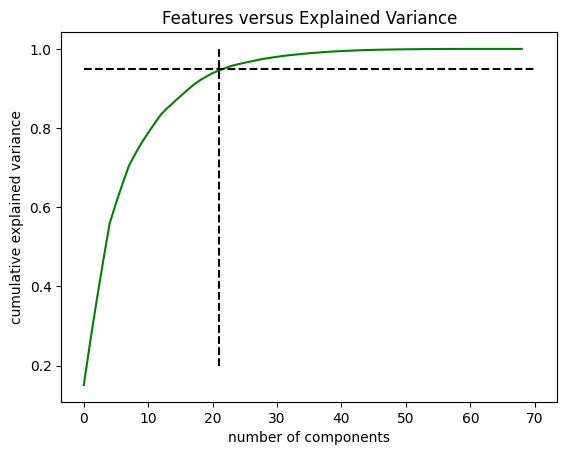

In [70]:
from matplotlib import pyplot as plt
plt.plot(np.cumsum(evr), color='g')
plt.title('Features versus Explained Variance')
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
#it looks like 21 features gets us there
plt.hlines(y=0.95, xmin=0, xmax=70, color='k', linestyle='--')
plt.vlines(x=21, ymin=0.2, ymax=1, color='k', linestyle='--');

Let's rerun PCA with this optimal components parameter in mind.

In [71]:
pca = PCA(n_components=21, random_state=210)
pca_array = pca.fit_transform(X_train_preprocessed)
evr = pca.explained_variance_ratio_
np.cumsum(evr)

array([0.15126788, 0.26161492, 0.36489109, 0.46366879, 0.55852288,
       0.61062163, 0.65888336, 0.70468066, 0.73563689, 0.76357858,
       0.78838025, 0.81201268, 0.83478108, 0.85117668, 0.86596044,
       0.88058668, 0.89502997, 0.90890505, 0.92053513, 0.93002147,
       0.93904649])

Now let's examine which features explain this variance best via the PCA's components attribute (aka its 'loadings'):

In [72]:
loadings = pca.components_
#rounding them to make comparisons a little easier
loadings_rounded = np.around(loadings, decimals=3)
#converting them to an easy-to-read Pandas Series
loadings_df = pd.DataFrame(loadings_rounded,columns=X_train_preprocessed.columns)
loadings_sums = pd.Series(loadings_df.sum()).sort_values(key=abs)
print(loadings_sums.to_string())

PERSON_TYPE_NON-CONTACT VEHICLE                0.000
WEATHER_CONDITION_SEVERE CROSS WIND GATE       0.000
SEX_X                                          0.000
WEATHER_CONDITION_BLOWING SAND, SOIL, DIRT     0.000
MANEUVER_PARKED IN TRAFFIC LANE               -0.002
MANEUVER_SLOW/STOP - RIGHT TURN               -0.003
MANEUVER_DRIVING WRONG WAY                    -0.003
MANEUVER_SLOW/STOP - LOAD/UNLOAD              -0.004
MANEUVER_NEGOTIATING A CURVE                  -0.004
LIGHTING_CONDITION_DAWN                        0.005
WEATHER_CONDITION_FOG/SMOKE/HAZE               0.005
MANEUVER_SLOW/STOP - LEFT TURN                -0.006
WEATHER_CONDITION_BLOWING SNOW                 0.009
MANEUVER_AVOIDING VEHICLES/OBJECTS            -0.010
MANEUVER_LEAVING TRAFFIC LANE TO PARK         -0.010
MANEUVER_ENTER FROM DRIVE/ALLEY               -0.011
WEATHER_CONDITION_SLEET/HAIL                   0.012
MANEUVER_SKIDDING/CONTROL LOSS                 0.012
WEATHER_CONDITION_FREEZING RAIN/DRIZZLE       

A wide range of cumulative explained variance ratios appear for these columns with the occasional large leap between groups. Those that appear to explain variance better include Wednesday crashes, the number of vehicles involved ('NUM_UNITS'), travelling east or north, gender, and when drivers were maneuvering straight ahead.

Of course, these columns don't necessarily *correlate* with the target. In fact, they likely *don't* since they capture so much of the variance in this dataset. However, gathering *all* these columns together suggests a trimmed group of columns that can still help get to the bottom of primary causes of accidents.

Among the less explanatory columns, we see a lot of rare classes from categorical features. While I got rid of many columns that showed the same kind of skewed distribution these columns have among their classes, these were a little better than most and seemed like they could still hold some pertitent information in regard to crash causes.

Let's begin by dropping any column that can't explain at least a *cumulative* absolute value of 0.1 of the variance. Below, we see that this will help trim our features down by just over half to 32. (Below, "e.v.r." stands for "explained variance ratio".)

In [73]:
loadings_sums_abs = loadings_sums.abs()
less_explanatory_loadings_sums = loadings_sums_abs[loadings_sums_abs < 0.1]
print('ratio of features below/above 0.1 cumulative e.v.r.:   ', round(len(less_explanatory_loadings_sums)/len(loadings_sums), 2))
print('remaining number of features after dropping those below 0.1 cumulative e.v.r.:   ', len(loadings_sums) - len(less_explanatory_loadings_sums))

ratio of features below/above 0.1 cumulative e.v.r.:    0.54
remaining number of features after dropping those below 0.1 cumulative e.v.r.:    32


In [74]:
#dropping less explanatory features
explanatory_loadings_sums = loadings_sums.drop(less_explanatory_loadings_sums.index, axis=0)
explanatory_loadings_sums

MANEUVER_BACKING                            -0.106
MANEUVER_PASSING/OVERTAKING                 -0.110
MANEUVER_TURNING RIGHT                      -0.130
CRASH_HOUR                                  -0.144
WEATHER_CONDITION_CLOUDY/OVERCAST            0.172
TRAVEL_DIRECTION_S                           0.179
MANEUVER_SLOW/STOP IN TRAFFIC                0.246
CRASH_DAY_OF_WEEK_5                          0.259
ROADWAY_SURFACE_COND_DRY                    -0.330
POSTED_SPEED_LIMIT                           0.391
LIGHTING_CONDITION_DARKNESS, LIGHTED ROAD    0.432
ROADWAY_SURFACE_COND_WET                    -0.446
WEATHER_CONDITION_RAIN                      -0.470
WEATHER_CONDITION_CLEAR                     -0.490
LIGHTING_CONDITION_DAYLIGHT                 -0.495
CRASH_DAY_OF_WEEK_2                          0.507
CRASH_DAY_OF_WEEK_3                         -0.603
LATITUDE                                     0.640
MANEUVER_TURNING LEFT                       -0.678
ROADWAY_SURFACE_COND_SNOW OR SL

This is one way to find our most promising features and get them down to a more reasonable quanitity before running them through a predictive model.

We can also try a similar process by way of a random forest. Once fit to our preprocessed training data, we can inspect its feature importances and see how well it matches our more promising features from PCA above.

## random forest feature importance

Since a random forest is a predictive model, we'll have to contend with the target column's class imbalance. Let's check and see how it appears here in our training data:

In [75]:
y_train.value_counts(normalize=True)

TARGET
1    0.927949
0    0.072051
Name: proportion, dtype: float64

Not good, but it could be much worse. Subsequently, we'll have to run our random forests with oversampling, undersampling, and SMOTE sampling strategies to get the best picture on which set of feature importances are ideal.

Before doing that, let's establish a baseline random forest model without any sampling strategies. This tree-based model will need the one-hot encoded categorical values, but the non-standardized numeric data.

In [76]:
X_train_nonstandardized = pd.concat([X_train_numeric, X_train_categorical_ohe], axis=1)
X_train_nonstandardized.head()

,POSTED_SPEED_LIMIT,NUM_UNITS,CRASH_HOUR,LATITUDE,LONGITUDE,AGE,"WEATHER_CONDITION_BLOWING SAND, SOIL, DIRT",WEATHER_CONDITION_BLOWING SNOW,WEATHER_CONDITION_CLEAR,WEATHER_CONDITION_CLOUDY/OVERCAST,...,MANEUVER_SKIDDING/CONTROL LOSS,MANEUVER_SLOW/STOP - LEFT TURN,MANEUVER_SLOW/STOP - LOAD/UNLOAD,MANEUVER_SLOW/STOP - RIGHT TURN,MANEUVER_SLOW/STOP IN TRAFFIC,MANEUVER_STARTING IN TRAFFIC,MANEUVER_STRAIGHT AHEAD,MANEUVER_TURNING LEFT,MANEUVER_TURNING RIGHT,MANEUVER_U-TURN
262116,30,2,9,41.870473,-87.630706,23.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
792637,30,2,10,41.975934,-87.678761,24.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
167787,35,2,8,41.663131,-87.641757,18.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
433111,30,2,20,41.838567,-87.609722,56.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
477277,30,2,15,41.684110,-87.717807,39.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [77]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, make_scorer
from sklearn.model_selection import GridSearchCV

#instantiating the random forest classifier
forest = RandomForestClassifier(random_state=210)

#Since this dataset has target class imbalance, let's
# evaluate its performance via an f1 score instead of the
# default accuracy.
f1 = make_scorer(f1_score)

#establishing a parameter grid for GridSearchCV
rf_param_grid = {'n_estimators':[5, 10],
                 'criterion':['entropy'],
                 'max_depth':[None, 4],
                 'min_samples_split':[10]}

#instantiating GridSearchCV
rf_grid_search = GridSearchCV(forest,
                              rf_param_grid,
                              cv=5,
                              return_train_score=True,
                              scoring=f1)

#fitting the GridSearch to the training data
rf_grid_search.fit(X_train_nonstandardized, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=210),
             param_grid={'criterion': ['entropy'], 'max_depth': [None, 4],
                         'min_samples_split': [10], 'n_estimators': [5, 10]},
             return_train_score=True, scoring=make_scorer(f1_score))

Before we can evaluate this random forest grid search on testing data, we have to perform one-hot encoding on X_test while refraining from standardizing its numerical columns in order to have an apples-to-apples evaluation.

In [78]:
#isolating X_test's categorical features
X_test_categorical = X_test[categorical_features]
#transforming them
X_test_categorical_ohe = ohe.transform(X_test_categorical)
#putting them back into a DataFrame
X_test_categorical_ohe = pd.DataFrame(X_test_categorical_ohe,
                                       columns = ohe.get_feature_names_out(),
                                       index = X_test_categorical.index)
#isolating X_test's numeric data
X_test_numeric = X_test[numeric_features]
#concatenating the non-standardized numeric data with the one-hot encoded categorical columns
X_test_nonstandardized = pd.concat([X_test_numeric, X_test_categorical_ohe], axis=1)
#making sure it looks right
X_test_nonstandardized.head()

,POSTED_SPEED_LIMIT,NUM_UNITS,CRASH_HOUR,LATITUDE,LONGITUDE,AGE,"WEATHER_CONDITION_BLOWING SAND, SOIL, DIRT",WEATHER_CONDITION_BLOWING SNOW,WEATHER_CONDITION_CLEAR,WEATHER_CONDITION_CLOUDY/OVERCAST,...,MANEUVER_SKIDDING/CONTROL LOSS,MANEUVER_SLOW/STOP - LEFT TURN,MANEUVER_SLOW/STOP - LOAD/UNLOAD,MANEUVER_SLOW/STOP - RIGHT TURN,MANEUVER_SLOW/STOP IN TRAFFIC,MANEUVER_STARTING IN TRAFFIC,MANEUVER_STRAIGHT AHEAD,MANEUVER_TURNING LEFT,MANEUVER_TURNING RIGHT,MANEUVER_U-TURN
713656,30,2,4,41.909357,-87.776124,59.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
558302,30,2,15,41.909271,-87.766971,68.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
414872,25,2,18,41.968622,-87.680912,81.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
697843,30,4,18,41.816404,-87.684794,34.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
306513,30,2,16,41.816395,-87.631340,41.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [79]:
#mean training score
rf_grid_search_train_score = rf_grid_search.cv_results_['mean_train_score'].mean()
#mean test score
rf_grid_search_test_score = rf_grid_search.score(X_test_nonstandardized, y_test)
#printing results
print(f'baseline random forest mean training score: {rf_grid_search_train_score :.2%}')
print(f'baseline random forest mean test score: {rf_grid_search_test_score :.2%}')
print(f'baseline random forest optimal parameter combination:', rf_grid_search.best_params_)

baseline random forest mean training score: 97.08%
baseline random forest mean test score: 97.01%
baseline random forest optimal parameter combination: {'criterion': 'entropy', 'max_depth': None, 'min_samples_split': 10, 'n_estimators': 10}


With a baseline that's been optimized via GridSearchCV in mind, let's (hopefully) further improve on this model by adding in some over/under sampling strategies.

In [80]:
#refresher on current state of y_train's distribution
y_train.value_counts()

TARGET
1    656758
0     50994
Name: count, dtype: int64

In [81]:
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import f1_score

#defining five over-sampling strategies from 110% to 150% of the
# minority target class in increments of 10%:
oversampling_strategies = [{0:56038, 1:656758}, {0:61133, 1:656758}, {0:66227, 1:656758}, {0:71321, 1:656758}, {0:76416, 1:656758}]

#empty list for f1 scores
f1_scores = []

#iterate through each sampling strategy
for i in oversampling_strategies:
    # define oversampling strategy
    oversample = RandomOverSampler(random_state=210, sampling_strategy=i)
    # fit and apply the oversampling strategy
    X_train_nonstandardized_over, y_train_over = oversample.fit_resample(X_train_nonstandardized, y_train)
    #instantiate & fit the model to X-over & y-over with previously optimized parameters
    forest_oversample_temp = RandomForestClassifier(criterion='entropy',
                                    max_depth=None,
                                    min_samples_split=10,
                                    n_estimators=10)
    forest_oversample_temp.fit(X_train_nonstandardized_over, y_train_over)
    #make predictions on test set
    y_hat = forest_oversample_temp.predict(X_test_nonstandardized)
    #find & append f1 score
    f1_scores.append(f1_score(y_test, y_hat))

oversampling_percentages = ['110%:', '120%:', '130%:', '140%:', '150%:']
print("sampling strategies & f1 scores:", list(zip(oversampling_percentages, f1_scores)))

sampling strategies & f1 scores: [('110%:', 0.9706822204535466), ('120%:', 0.971113898018984), ('130%:', 0.9713335732363411), ('140%:', 0.971791964623154), ('150%:', 0.971974252889997)]


It looks like over-sampling at 150% works best; let's see whether under-sampling will outperform it.

In [82]:
from imblearn.under_sampling import RandomUnderSampler

#defining five under-sampling strategies from 50% to 90% of the
# majority target class in increments of 10%:
undersampling_strategies = [{0:50994, 1:328379}, {0:50994, 1:394055}, {0:50994, 1:459731}, {0:50994, 1:525407}, {0:50994, 1:591082}]

#empty list for f1 scores
f1_scores = []

#iterate through each sampling strategy
for i in undersampling_strategies:
    # define undersampling strategy
    undersample = RandomUnderSampler(random_state=210, sampling_strategy=i)
    # fit and apply the undersampling strategy
    X_train_nonstandardized_under, y_train_under = undersample.fit_resample(X_train_nonstandardized, y_train)
    #instantiate & fit the model to X-over & y-over with previously optimized parameters
    forest_undersample_temp = RandomForestClassifier(criterion='entropy',
                                    max_depth=None,
                                    min_samples_split=10,
                                    n_estimators=10)
    forest_undersample_temp.fit(X_train_nonstandardized_under, y_train_under)
    #make predictions on test set
    y_hat = forest_undersample_temp.predict(X_test_nonstandardized)
    #find & append f1 score
    f1_scores.append(f1_score(y_test, y_hat))

undersampling_percentages = ['50%:', '60%:', '70%:', '80%:', '90%:']
print("sampling strategies & f1 scores:", list(zip(undersampling_percentages, f1_scores)))

sampling strategies & f1 scores: [('50%:', 0.9687402743530201), ('60%:', 0.9700047441019474), ('70%:', 0.9699994939888855), ('80%:', 0.9702869614084332), ('90%:', 0.970337712461961)]


So far, it looks like oversampling the minority class at 150% of its original value count produces the highest f1 score (0.9719). Before investigating this particular model's feature importances, let's try one more sampling strategy by way of SMOTE.

In [83]:
from imblearn.over_sampling import SMOTE

#empty list for f1 scores
f1_scores = []

#iterate through each SMOTE oversampling strategy
for i in oversampling_strategies:
    smote = SMOTE(random_state=210, sampling_strategy=i)
    # fit the smote-oversampling strategy
    X_train_nonstandardized_smote, y_train_smote = smote.fit_resample(X_train_nonstandardized, y_train)
    #instantiate & fit the random forest model to X-smote & y-smote with previously optimized parameters
    forest_smote_temp = RandomForestClassifier(criterion='entropy',
                                    max_depth=None,
                                    min_samples_split=10,
                                    n_estimators=10)
    forest_smote_temp.fit(X_train_nonstandardized_smote, y_train_smote)
    #make predictions on test set
    y_hat = forest_smote_temp.predict(X_test_nonstandardized)
    #find & append f1 score
    f1_scores.append(f1_score(y_test, y_hat))

smote_oversampling_percentages = ['110%:', '120%:', '130%:', '140%:', '150%:']
print("sampling strategies & f1 scores:", list(zip(smote_oversampling_percentages, f1_scores)))

sampling strategies & f1 scores: [('110%:', 0.9702435000385754), ('120%:', 0.9703004383556765), ('130%:', 0.9702982645776664), ('140%:', 0.9703725484954601), ('150%:', 0.9702587986491262)]


It turns out that oversampling the minorty class by 150% is still our best route. Let's examine its feature importances and compare them to our PCA's less_explanatory_loadings_sums variable in order to make a more informed decision on which columns to drop.

In [84]:
#reestablishing the best random forest model (150% oversampled minority target class data)
oversample = RandomOverSampler(random_state=210, sampling_strategy={0:76416, 1:656758})
X_train_nonstandardized_over, y_train_over = oversample.fit_resample(X_train_nonstandardized, y_train)
final_forest_model = RandomForestClassifier(criterion='entropy',
                                            max_depth=None,
                                            min_samples_split=10,
                                            n_estimators=10)
final_forest_model.fit(X_train_nonstandardized_over, y_train_over)

#gathering its feature importances
forest_feature_importances = final_forest_model.feature_importances_
forest_feature_importances

array([3.62981562e-02, 6.83310847e-02, 8.33255858e-02, 1.56524578e-01,
       1.57648254e-01, 1.12501206e-01, 9.23115500e-09, 4.69605065e-04,
       2.88336638e-02, 3.61275593e-03, 5.57175082e-04, 1.16888041e-03,
       6.88177553e-03, 3.09221376e-04, 6.76404984e-04, 1.50672936e-02,
       4.47623600e-03, 7.36998999e-03, 3.06179413e-03, 7.86498919e-03,
       4.18902331e-03, 2.18328306e-02, 1.73449070e-02, 1.78930371e-02,
       1.16906177e-02, 9.31200772e-03, 1.06905709e-02, 1.05028231e-02,
       1.01599826e-02, 1.08153253e-02, 1.11230280e-02, 1.04958396e-02,
       7.61062879e-04, 2.06351622e-03, 1.85004591e-04, 1.61154572e-03,
       7.18034715e-03, 7.22812275e-03, 2.92926588e-04, 1.16085651e-02,
       1.20982106e-02, 2.53454122e-03, 3.01172908e-03, 1.16408733e-02,
       3.25090289e-03, 2.75037932e-03, 1.17924556e-02, 7.32491891e-03,
       3.32948578e-03, 2.73991799e-03, 5.77776044e-04, 1.53829828e-03,
       1.69846498e-03, 9.40904145e-04, 1.24656476e-03, 8.33587470e-04,
      

In [85]:
fi_rounded = np.around(forest_feature_importances, decimals=3)
fi_series = pd.Series(fi_rounded, index=X_train_nonstandardized.columns).sort_values(key=abs)
print(fi_series.to_string())

PERSON_TYPE_NON-CONTACT VEHICLE                0.000
MANEUVER_SLOW/STOP - RIGHT TURN                0.000
MANEUVER_SLOW/STOP - LOAD/UNLOAD               0.000
WEATHER_CONDITION_BLOWING SAND, SOIL, DIRT     0.000
WEATHER_CONDITION_BLOWING SNOW                 0.000
SEX_X                                          0.000
WEATHER_CONDITION_SEVERE CROSS WIND GATE       0.000
MANEUVER_SLOW/STOP - LEFT TURN                 0.001
MANEUVER_PARKED IN TRAFFIC LANE                0.001
MANEUVER_NEGOTIATING A CURVE                   0.001
MANEUVER_MERGING                               0.001
MANEUVER_LEAVING TRAFFIC LANE TO PARK          0.001
MANEUVER_DRIVING WRONG WAY                     0.001
PERSON_TYPE_BICYCLE                            0.001
MANEUVER_U-TURN                                0.001
WEATHER_CONDITION_FOG/SMOKE/HAZE               0.001
WEATHER_CONDITION_SLEET/HAIL                   0.001
WEATHER_CONDITION_FREEZING RAIN/DRIZZLE        0.001
PERSON_TYPE_PEDESTRIAN                        

Let's get a resfresher on how the PCA evr/loadings looked - below we note how they seem to be working on a different scale because they're the sum of 21 rows-worth of loadings.

We should also keep in mind that PCA loadings show a different perspective of variance as opposed to a random forest's feature importances, which show how a target prediction for a test crash would be routed through the decision tree process, so there's definitely an aspect of correlation in the latter case.

In [86]:
loadings_sums

PERSON_TYPE_NON-CONTACT VEHICLE               0.000
WEATHER_CONDITION_SEVERE CROSS WIND GATE      0.000
SEX_X                                         0.000
WEATHER_CONDITION_BLOWING SAND, SOIL, DIRT    0.000
MANEUVER_PARKED IN TRAFFIC LANE              -0.002
                                              ...  
SEX_F                                         1.211
SEX_M                                        -1.212
TRAVEL_DIRECTION_E                            1.218
NUM_UNITS                                     1.918
CRASH_DAY_OF_WEEK_4                          -1.939
Length: 69, dtype: float64

Due to the different range here, let's scale them down to their average by dividing them by 21 before comparing them to the random forest's feature importances.

In [87]:
loadings_sums_scaled = loadings_sums/21
loadings_sums_scaled

PERSON_TYPE_NON-CONTACT VEHICLE               0.000000
WEATHER_CONDITION_SEVERE CROSS WIND GATE      0.000000
SEX_X                                         0.000000
WEATHER_CONDITION_BLOWING SAND, SOIL, DIRT    0.000000
MANEUVER_PARKED IN TRAFFIC LANE              -0.000095
                                                ...   
SEX_F                                         0.057667
SEX_M                                        -0.057714
TRAVEL_DIRECTION_E                            0.058000
NUM_UNITS                                     0.091333
CRASH_DAY_OF_WEEK_4                          -0.092333
Length: 69, dtype: float64

Now we can visualize these alongside the PCA loadings to get a better handle on how they compare.

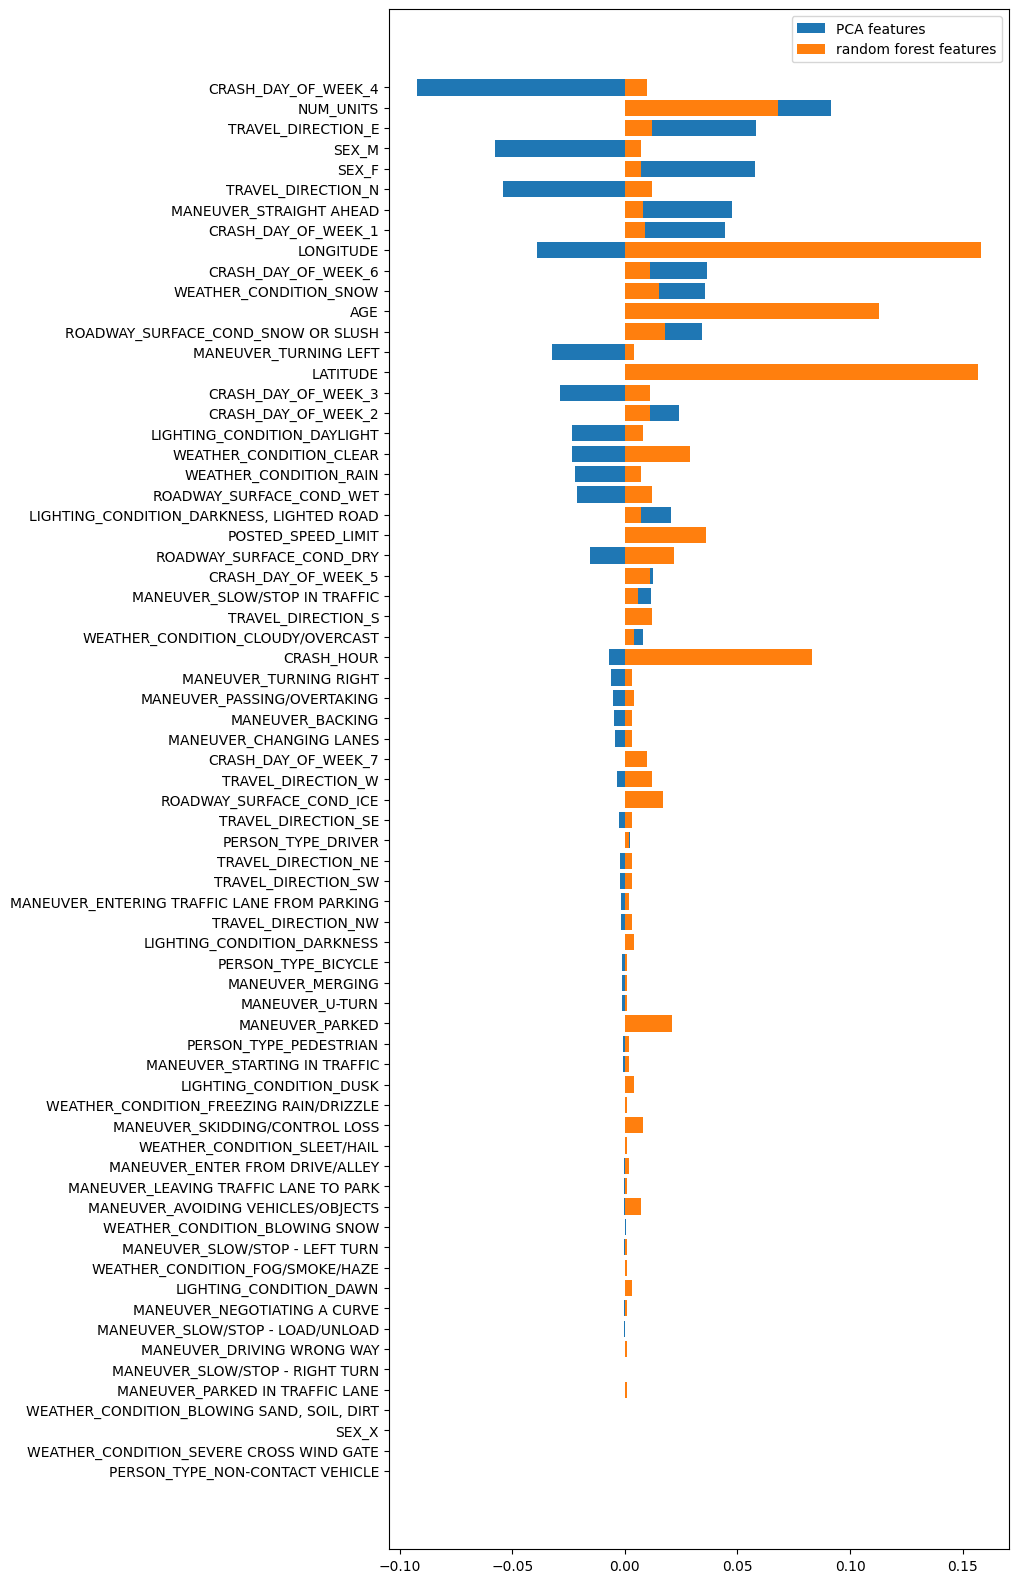

In [88]:
fig, ax = plt.subplots(figsize=(8,20))
ax.barh(loadings_sums_scaled.index, loadings_sums_scaled.values, label='PCA features')
ax.barh(fi_series.index, fi_series.values, label='random forest features')
plt.legend();

PCA loadings and random forest features certainly show different perspectives on a lot of these columns. Generally speaking, though, they tend to agree on a *lot* of columns that don't seem to contribute much to variance or our target. Specifically, it appears that any columns at or below 'TRAVEL_DIRECTION_SE' can be dropped, but we'll keep 'MANEUVER_PARKED', 'MANEUVER_SKIDDING/CONTROL LOSS', and 'MANEUVER_AVODING VEHICLES/OBJECTS' since the random forest is attributing a bit more significance to them than their neighbors in this chart.

In [89]:
preliminary_columns_to_drop = ['PERSON_TYPE_DRIVER', 'TRAVEL_DIRECTION_NW', 'TRAVEL_DIRECTION_NE', 'TRAVEL_DIRECTION_SW', 'MANEUVER_ENTERING TRAFFIC LANE FROM PARKING',
                               'PERSON_TYPE_PEDESTRIAN', 'MANEUVER_MERGING', 'PERSON_TYPE_BICYCLE', 'MANEUVER_STARTING IN TRAFFIC', 'MANEUVER_U-TURN',
                               'WEATHER_CONDITION_SLEET/HAIL', 'WEATHER_CONDITION_FREEZING RAIN/DRIZZLE', 'MANEUVER_ENTER FROM DRIVE/ALLEY', 'LIGHTING_CONDITION_DUSK',
                               'WEATHER_CONDITION_FOG/SMOKE/HAZE', 'WEATHER_CONDITION_BLOWING SNOW', 'MANEUVER_LEAVING TRAFFIC LANE TO PARK', 'LIGHTING_CONDITION_DAWN',
                               'MANEUVER_SLOW/STOP - LEFT TURN', 'MANEUVER_SLOW/STOP - RIGHT TURN', 'MANEUVER_DRIVING WRONG WAY', 'MANEUVER_SLOW/STOP - LOAD/UNLOAD',
                               'MANEUVER_NEGOTIATING A CURVE', 'MANEUVER_PARKED IN TRAFFIC LANE', 'SEX_X', 'WEATHER_CONDITION_BLOWING SAND, SOIL, DIRT',
                               'WEATHER_CONDITION_SEVERE CROSS WIND GATE', 'PERSON_TYPE_NON-CONTACT VEHICLE', 'LIGHTING_CONDITION_DARKNESS', 'TRAVEL_DIRECTION_SE']

Now that we know which columns to run our white-box models with, we can drop them from our training data. Since we'll employ a Logistic Regression model and an individual decision tree model next, we'll actually need to drop these columns from the two training data sets. Both have the categorical variables one-hot encoded, but one has standardized numeric data (important for the Logit model) while the other's is not standardized (meant for the decision tree).

In [90]:
X_train_trimmed_and_stnd = X_train_preprocessed.drop(preliminary_columns_to_drop, axis=1)
X_train_trimmed_and_stnd.info()

<class 'pandas.core.frame.DataFrame'>
Index: 707752 entries, 262116 to 303626
Data columns (total 39 columns):
 #   Column                                     Non-Null Count   Dtype  
---  ------                                     --------------   -----  
 0   POSTED_SPEED_LIMIT                         707752 non-null  float64
 1   NUM_UNITS                                  707752 non-null  float64
 2   CRASH_HOUR                                 707752 non-null  float64
 3   LATITUDE                                   707752 non-null  float64
 4   LONGITUDE                                  707752 non-null  float64
 5   AGE                                        707752 non-null  float64
 6   WEATHER_CONDITION_CLEAR                    707752 non-null  float64
 7   WEATHER_CONDITION_CLOUDY/OVERCAST          707752 non-null  float64
 8   WEATHER_CONDITION_RAIN                     707752 non-null  float64
 9   WEATHER_CONDITION_SNOW                     707752 non-null  float64
 10  LIGHTING

In [91]:
X_train_trimmed_and_non_stnd = X_train_nonstandardized.drop(preliminary_columns_to_drop, axis=1)
X_train_trimmed_and_non_stnd.info()

<class 'pandas.core.frame.DataFrame'>
Index: 707752 entries, 262116 to 303626
Data columns (total 39 columns):
 #   Column                                     Non-Null Count   Dtype  
---  ------                                     --------------   -----  
 0   POSTED_SPEED_LIMIT                         707752 non-null  int64  
 1   NUM_UNITS                                  707752 non-null  int64  
 2   CRASH_HOUR                                 707752 non-null  int64  
 3   LATITUDE                                   707752 non-null  float64
 4   LONGITUDE                                  707752 non-null  float64
 5   AGE                                        707752 non-null  float64
 6   WEATHER_CONDITION_CLEAR                    707752 non-null  float64
 7   WEATHER_CONDITION_CLOUDY/OVERCAST          707752 non-null  float64
 8   WEATHER_CONDITION_RAIN                     707752 non-null  float64
 9   WEATHER_CONDITION_SNOW                     707752 non-null  float64
 10  LIGHTING

# white-box predictive modeling

With an long process of column-trimming complete by way of domain knowledge (in the data engineering notebook) and through modeling (above), we can now fit our trimmed-down columns to two white-box models that will hopefully make sound predictions while remaining relatively simple to interpret for the non-technical stakeholder.

First, we'll run a StatsModels Logitistic Regression to see the statistical significance of each column.

In [92]:
import statsmodels.api as sm
#adding the constant to X_train
X = sm.add_constant(X_train_trimmed_and_stnd)
#instantiating & fitting the Logit model
logit_model = sm.Logit(y_train.astype(float), X.astype(float))
baseline_result = logit_model.fit(maxiter=3500)
#checking the results
baseline_result.summary()

Optimization terminated successfully.
         Current function value: 0.228538
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 TARGET   No. Observations:               707752
Model:                          Logit   Df Residuals:                   707714
Method:                           MLE   Df Model:                           37
Date:                Fri, 24 May 2024   Pseudo R-squ.:                  0.1173
Time:                        22:26:23   Log-Likelihood:            -1.6175e+05
converged:                       True   LL-Null:                   -1.8325e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
=============================================================================================================
                                                coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------
const                                         0.9920   1.35e+05   7.34e-06      1.000   -2.65e+05    2.65e+05
POSTED_SPEED_LIMIT                            0.0025      0.005      0.510      0.610      -0.007       0.012
NUM_UNITS                                    -0.0020      0.004     -0.456      0.649      -0.010       0.006
CRASH_HOUR                                    0.1008      0.005     21.585      0.000       0.092       0.110
LATITUDE                                      0.0671      0.006     12.043      0.000       0.056       0.078
LONGITUDE                                    -0.0202      0.006     -3.607      0.000      -0.031      -0.009
AGE                                          -0.0383      0.005     -7.827      0.000      -0.048      -0.029
WEATHER_CONDITION_CLEAR                       0.9515      0.041     23.410      0.000       0.872       1.031
WEATHER_CONDITION_CLOUDY/OVERCAST             0.7653      0.046     16.495      0.000       0.674       0.856
WEATHER_CONDITION_RAIN                        0.1756      0.041      4.327      0.000       0.096       0.255
WEATHER_CONDITION_SNOW                        0.0072      0.041      0.173      0.863      -0.074       0.088
LIGHTING_CONDITION_DARKNESS, LIGHTED ROAD    -0.0259      0.018     -1.408      0.159      -0.062       0.010
LIGHTING_CONDITION_DAYLIGHT                   0.0597      0.017      3.505      0.000       0.026       0.093
ROADWAY_SURFACE_COND_DRY                      1.2853        nan        nan        nan         nan         nan
ROADWAY_SURFACE_COND_ICE                     -1.2118        nan        nan        nan         nan         nan
ROADWAY_SURFACE_COND_SNOW OR SLUSH           -0.0116        nan        nan        nan         nan         nan
ROADWAY_SURFACE_COND_WET                      0.9300        nan        nan        nan         nan         nan
CRASH_DAY_OF_WEEK_1                           0.1633        nan        nan        nan         nan         nan
CRASH_DAY_OF_WEEK_2                           0.1283        nan        nan        nan         nan         nan
CRASH_DAY_OF_WEEK_3                           0.1033        nan        nan        nan         nan         nan
CRASH_DAY_OF_WEEK_4                           0.1376        nan        nan        nan         nan         nan
CRASH_DAY_OF_WEEK_5                           0.1604        nan        nan        nan         nan         nan
CRASH_DAY_OF_WEEK_6                           0.1258        nan        nan        nan         nan         nan
CRASH_DAY_OF_WEEK_7                           0.1733        nan        nan        nan         nan         nan
SEX_F                                        -0.0826      0.168     -0.492      0.623      -0.412       0.247
SEX_M                                        -0.1954      0.168     -1.164      0.245      -0.524       0.134
TRAVEL_DIRECTION_E                            0.064

These results are horrendous, but I think a big part of the problem is the fact that a few categorical columns in the dataset - 'ROADWAY_SURFACE_COND' and 'CRASH_DAY_OF_WEEK' - have not had any of their constituent one-hot encoded classes dropped yet, which results in multicollinearity issues. Subsequently, both of these column-groups need to have an ohe-class column dropped. The silver lining is that we won't have to do this when we run the decision tree model.

In any case, [it's important to carefully consider *which* class to drop](https://towardsdatascience.com/drop-first-can-hurt-your-ols-regression-models-interpretability-4ca529cfb707) and not just arbitrarily drop the first one. Let's take a look at the first column in question:

In [93]:
X_train_categorical['ROADWAY_SURFACE_COND'].value_counts()

ROADWAY_SURFACE_COND
DRY              561675
WET              114059
SNOW OR SLUSH     26158
ICE                5860
Name: count, dtype: int64

One one hand, we may think to drop the 'DRY' class because it's a go-to standard driving time that we'd be inclined to compare other, less common weather conditions to. However, dropping 'DRY' rows would also drop almost 80% of our rows, so let's *not* do that.

Fortunately, we do have grounds to drop the class with the most average coefficient among the road condition classes, which would be 'SNOW OR SLUSH' and that only results in a row loss of 4% - much more managable. Dropping this class means that we'll need to recognize that the remaining 'ROADWAY_SURFACE_COND' columns reference back to their median class of 'SNOW OR SLUSH'.

With that decided, let's also take a look at 'CRASH_DAY_OF_WEEK' value counts:

In [94]:
X_train_categorical['CRASH_DAY_OF_WEEK'].value_counts()

CRASH_DAY_OF_WEEK
6    118225
5    104241
3    103016
7    102611
4    102461
2     96246
1     80952
Name: count, dtype: int64

This is not great news - the median coefficient class from our results puts '4' (Wednesday) as the median class, which will result in the loss of 102,742 rows from our data, but doing so will make our StatsModels Logit results interpretable, so we have to do it.

In [95]:
preliminary_columns_to_drop_for_statsmodels = ['ROADWAY_SURFACE_COND_SNOW OR SLUSH', 'CRASH_DAY_OF_WEEK_4']

In [96]:
#dropping the classes
X_train_trimmed_and_stnd_for_Logit = X_train_trimmed_and_stnd.drop(preliminary_columns_to_drop_for_statsmodels, axis=1)
#refitting the model
X = sm.add_constant(X_train_trimmed_and_stnd_for_Logit)
#instantiating & fitting the Logit model
logit_model = sm.Logit(y_train.astype(float), X.astype(float))
baseline_result = logit_model.fit(maxiter=3500)
#checking the results
baseline_result.summary()

Optimization terminated successfully.
         Current function value: 0.228538
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 TARGET   No. Observations:               707752
Model:                          Logit   Df Residuals:                   707714
Method:                           MLE   Df Model:                           37
Date:                Fri, 24 May 2024   Pseudo R-squ.:                  0.1173
Time:                        22:26:32   Log-Likelihood:            -1.6175e+05
converged:                       True   LL-Null:                   -1.8325e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
=============================================================================================================
                                                coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------
const                                         1.1180      0.176      6.340      0.000       0.772       1.464
POSTED_SPEED_LIMIT                            0.0025      0.005      0.510      0.610      -0.007       0.012
NUM_UNITS                                    -0.0020      0.004     -0.456      0.649      -0.010       0.006
CRASH_HOUR                                    0.1008      0.005     21.585      0.000       0.092       0.110
LATITUDE                                      0.0671      0.006     12.043      0.000       0.056       0.078
LONGITUDE                                    -0.0202      0.006     -3.607      0.000      -0.031      -0.009
AGE                                          -0.0383      0.005     -7.827      0.000      -0.048      -0.029
WEATHER_CONDITION_CLEAR                       0.9515      0.041     23.410      0.000       0.872       1.031
WEATHER_CONDITION_CLOUDY/OVERCAST             0.7653      0.046     16.495      0.000       0.674       0.856
WEATHER_CONDITION_RAIN                        0.1756      0.041      4.327      0.000       0.096       0.255
WEATHER_CONDITION_SNOW                        0.0072      0.041      0.173      0.863      -0.074       0.088
LIGHTING_CONDITION_DARKNESS, LIGHTED ROAD    -0.0259      0.018     -1.408      0.159      -0.062       0.010
LIGHTING_CONDITION_DAYLIGHT                   0.0597      0.017      3.505      0.000       0.026       0.093
ROADWAY_SURFACE_COND_DRY                      1.2969      0.025     51.707      0.000       1.248       1.346
ROADWAY_SURFACE_COND_ICE                     -1.2002      0.034    -35.764      0.000      -1.266      -1.134
ROADWAY_SURFACE_COND_WET                      0.9416      0.025     37.836      0.000       0.893       0.990
CRASH_DAY_OF_WEEK_1                           0.0257      0.019      1.341      0.180      -0.012       0.063
CRASH_DAY_OF_WEEK_2                          -0.0093      0.018     -0.504      0.615      -0.045       0.027
CRASH_DAY_OF_WEEK_3                          -0.0343      0.018     -1.899      0.058      -0.070       0.001
CRASH_DAY_OF_WEEK_5                           0.0228      0.018      1.253      0.210      -0.013       0.059
CRASH_DAY_OF_WEEK_6                          -0.0118      0.018     -0.672      0.502      -0.046       0.023
CRASH_DAY_OF_WEEK_7                           0.0357      0.018      1.966      0.049       0.000       0.071
SEX_F                                        -0.0826      0.168     -0.492      0.623      -0.412       0.247
SEX_M                                        -0.1954      0.168     -1.164      0.245      -0.524       0.134
TRAVEL_DIRECTION_E                            0.0647      0.025      2.613      0.009       0.016       0.113
TRAVEL_DIRECTION_N                            0.0626      0.025      2.549      0.011       0.014       0.111
TRAVEL_DIRECTION_S                            0.013

There are a ton of variables that aren't statisitically significant here (having a P>[z] value greater than 0.05). This does not necessarily mean we should drop them, too; sometimes they can help the model and we just don't drop too many conclusions from those features. However, with 42 columns in a StatsModels Logit model, we're still dealing with a lot of noise here.

Now that we have a real baseline, we can go through and also drop the features that are not statistically significant to finally get down to the factors that correlate with accidents that are avoidable, which would include the following.

This is a lot to drop, but we can already see that these columns have little to do with what makes an accident avoidable (and a solution actionable). Travel direction, gender, and day of the week have shown value counts with little variance among them, so it makes sense to see that they don't contribute much to our model.

In [97]:
insignificant_columns_to_drop = ['POSTED_SPEED_LIMIT', 'NUM_UNITS', 'WEATHER_CONDITION_SNOW',
                                 'LIGHTING_CONDITION_DARKNESS, LIGHTED ROAD', 'CRASH_DAY_OF_WEEK_1',
                                 'CRASH_DAY_OF_WEEK_2', 'CRASH_DAY_OF_WEEK_3', 'CRASH_DAY_OF_WEEK_5',
                                 'CRASH_DAY_OF_WEEK_6', 'SEX_F', 'SEX_M', 'TRAVEL_DIRECTION_S',
                                 'MANEUVER_BACKING']

In [98]:
#dropping the classes
X_train_trimmed_and_stnd_for_Logit = X_train_trimmed_and_stnd_for_Logit.drop(insignificant_columns_to_drop, axis=1)
#refitting the model
X = sm.add_constant(X_train_trimmed_and_stnd_for_Logit)
#instantiating & fitting the Logit model
logit_model = sm.Logit(y_train.astype(float), X.astype(float))
statistically_significant_Logit = logit_model.fit(maxiter=3500)
#checking the results
statistically_significant_Logit.summary()

Optimization terminated successfully.
         Current function value: 0.228643
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 TARGET   No. Observations:               707752
Model:                          Logit   Df Residuals:                   707727
Method:                           MLE   Df Model:                           24
Date:                Fri, 24 May 2024   Pseudo R-squ.:                  0.1169
Time:                        22:26:38   Log-Likelihood:            -1.6182e+05
converged:                       True   LL-Null:                   -1.8325e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
======================================================================================================
                                         coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
const                                  0.9830      0.025     38.622      0.000       0.933       1.033
CRASH_HOUR                             0.1005      0.005     21.611      0.000       0.091       0.110
LATITUDE                               0.0635      0.006     11.418      0.000       0.053       0.074
LONGITUDE                             -0.0204      0.006     -3.646      0.000      -0.031      -0.009
AGE                                   -0.0410      0.005     -8.395      0.000      -0.051      -0.031
WEATHER_CONDITION_CLEAR                0.9436      0.023     40.534      0.000       0.898       0.989
WEATHER_CONDITION_CLOUDY/OVERCAST      0.7589      0.032     23.480      0.000       0.696       0.822
WEATHER_CONDITION_RAIN                 0.1704      0.024      7.017      0.000       0.123       0.218
LIGHTING_CONDITION_DAYLIGHT            0.0834      0.011      7.911      0.000       0.063       0.104
ROADWAY_SURFACE_COND_DRY               1.2983      0.025     52.932      0.000       1.250       1.346
ROADWAY_SURFACE_COND_ICE              -1.2008      0.033    -36.479      0.000      -1.265      -1.136
ROADWAY_SURFACE_COND_WET               0.9409      0.024     38.960      0.000       0.894       0.988
CRASH_DAY_OF_WEEK_7                    0.0341      0.014      2.487      0.013       0.007       0.061
TRAVEL_DIRECTION_E                     0.0537      0.013      3.985      0.000       0.027       0.080
TRAVEL_DIRECTION_N                     0.0516      0.013      3.940      0.000       0.026       0.077
TRAVEL_DIRECTION_W                     0.0844      0.014      6.211      0.000       0.058       0.111
MANEUVER_AVOIDING VEHICLES/OBJECTS    -2.2086      0.043    -51.789      0.000      -2.292      -2.125
MANEUVER_CHANGING LANES                0.7988      0.057     14.049      0.000       0.687       0.910
MANEUVER_PARKED                       -1.4978      0.024    -61.432      0.000      -1.546      -1.450
MANEUVER_PASSING/OVERTAKING            1.0834      0.056     19.396      0.000       0.974       1.193
MANEUVER_SKIDDING/CONTROL LOSS        -2.0943      0.042    -49.906      0.000      -2.177      -2.012
MANEUVER_SLOW/STOP IN TRAFFIC         -0.4237      0.024    -17.958      0.000      -0.470      -0.377
MANEUVER_STRAIGHT AHEAD               -0.2785      0.020    -14.019      0.000      -0.317      -0.240
MANEUVER_TURNING LEFT                  0.0955      0.027      3.505      0.000       0.042       0.149
MANEUVER_TURNING RIGHT                -0.1033      0.033     -3.172      0.002      -0.167      -0.039
======================================================================================================
"""

Now we have a more reasonable model with all statisitically significant features. Before we try and optimize it via over/under-sampling, let's evaluate its performance via a confusion matrix to see how well it's predicting the target values in our test set.

In [99]:
#First, we need to reformat X_test to be comprable to X_train_trimmed_and_stnd_for_Logit.
# So far, we've reformatted X_test to include one-hot encoded categorical columns,
# but non-standardized numerical data, so we need to (1) bring in those standardized columns,
# (2) bring in the categorical ones, then (3) drop every column we've dropped so far.

#transforming X_test numeric data
X_test_numeric_stnd = scaler.transform(X_test_numeric)
X_test_numeric_stnd = pd.DataFrame(X_test_numeric_stnd,
                                   columns=X_test_numeric.columns,
                                   index=X_test_numeric.index)

#bringing X_test's pre-ohe columns back in
X_test_trimmed_and_stnd_for_Logit = pd.concat([X_test_numeric_stnd, X_test_categorical_ohe], axis=1)

#dropping the columns we dropped from the training data
X_test_trimmed_and_stnd_for_Logit.drop(preliminary_columns_to_drop, axis=1, inplace=True)
X_test_trimmed_and_stnd_for_Logit.drop(preliminary_columns_to_drop_for_statsmodels, axis=1, inplace=True)
X_test_trimmed_and_stnd_for_Logit.drop(insignificant_columns_to_drop, axis=1, inplace=True)

X_test_trimmed_and_stnd_for_Logit.info()

<class 'pandas.core.frame.DataFrame'>
Index: 176939 entries, 713656 to 146602
Data columns (total 24 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   CRASH_HOUR                          176939 non-null  float64
 1   LATITUDE                            176939 non-null  float64
 2   LONGITUDE                           176939 non-null  float64
 3   AGE                                 176939 non-null  float64
 4   WEATHER_CONDITION_CLEAR             176939 non-null  float64
 5   WEATHER_CONDITION_CLOUDY/OVERCAST   176939 non-null  float64
 6   WEATHER_CONDITION_RAIN              176939 non-null  float64
 7   LIGHTING_CONDITION_DAYLIGHT         176939 non-null  float64
 8   ROADWAY_SURFACE_COND_DRY            176939 non-null  float64
 9   ROADWAY_SURFACE_COND_ICE            176939 non-null  float64
 10  ROADWAY_SURFACE_COND_WET            176939 non-null  float64
 11  CRASH_DAY_OF_WEEK_7       

In [100]:
X_test_trimmed_and_stnd_for_Logit['CONST'] = 1
#X_test_trimmed_and_stnd_for_Logit = X_test_trimmed_and_stnd_for_Logit.insert(0, 'CONST', 1)
#cols.insert(0, cols.pop(cols.index('Mid')))
X_test_trimmed_and_stnd_for_Logit.info()

<class 'pandas.core.frame.DataFrame'>
Index: 176939 entries, 713656 to 146602
Data columns (total 25 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   CRASH_HOUR                          176939 non-null  float64
 1   LATITUDE                            176939 non-null  float64
 2   LONGITUDE                           176939 non-null  float64
 3   AGE                                 176939 non-null  float64
 4   WEATHER_CONDITION_CLEAR             176939 non-null  float64
 5   WEATHER_CONDITION_CLOUDY/OVERCAST   176939 non-null  float64
 6   WEATHER_CONDITION_RAIN              176939 non-null  float64
 7   LIGHTING_CONDITION_DAYLIGHT         176939 non-null  float64
 8   ROADWAY_SURFACE_COND_DRY            176939 non-null  float64
 9   ROADWAY_SURFACE_COND_ICE            176939 non-null  float64
 10  ROADWAY_SURFACE_COND_WET            176939 non-null  float64
 11  CRASH_DAY_OF_WEEK_7       

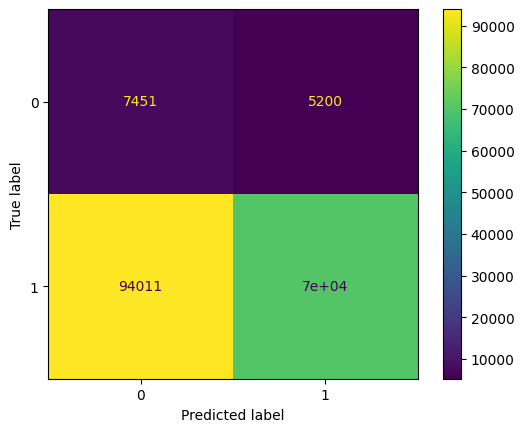

In [101]:
#making our y_test predictions
y_pred_test = round(statistically_significant_Logit.predict(X_test_trimmed_and_stnd_for_Logit), 0)

#confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test);

In [102]:
from sklearn.metrics import classification_report
target_names = ['0', '1']
print(classification_report(y_test, y_pred_test, target_names = target_names))

              precision    recall  f1-score   support

           0       0.07      0.59      0.13     12651
           1       0.93      0.43      0.59    164288

    accuracy                           0.44    176939
   macro avg       0.50      0.51      0.36    176939
weighted avg       0.87      0.44      0.55    176939



That is atrocious, but it's almost certainly because we haven't yet addressed class imbalance.

In [ ]:
#empty list for f1 scores
f1_scores = []

#iterate through each sampling strategy
for i in undersampling_strategies:
    # define undersampling strategy
    undersample = RandomUnderSampler(random_state=210, sampling_strategy=i)
    # fit and apply the undersampling strategy
    X_train_trimmed_and_stnd_for_Logit_under, y_train_under = undersample.fit_resample(X_train_trimmed_and_stnd_for_Logit, y_train)
    #instantiate & fit the model to X-over & y-over
    X_under = sm.add_constant(X_train_trimmed_and_stnd_for_Logit_under)
    temp_logit_model = sm.Logit(y_train_under.astype(float), X_under.astype(float))
    temp_logit_model = temp_logit_model.fit(maxiter=3500)
    #make predictions on test set
    y_hat = round(temp_logit_model.predict(X_under), 0)
    #find & append f1 score
    f1_scores.append(f1_score(y_train_under, y_hat))

undersampling_percentages = ['50%:', '60%:', '70%:', '80%:', '90%:']
print("sampling strategies & f1 scores:", list(zip(undersampling_percentages, f1_scores)))

Undersampling at 90% gets the best score so far, now let's try oversampling.

In [ ]:
#refresher on the oversampling strategies
oversampling_strategies = [{0:55969, 1:656936}, {0:61057, 1:656936}, {0:66145, 1:656936}, {0:71233, 1:656936}, {0:76322, 1:656936}]

#empty list for f1 scores
f1_scores = []

#iterate through each sampling strategy
for i in oversampling_strategies:
    # define oversampling strategy
    oversample = RandomOverSampler(random_state=210, sampling_strategy=i)
    # fit and apply the oversampling strategy
    X_train_trimmed_and_stnd_for_Logit_over, y_train_over = oversample.fit_resample(X_train_trimmed_and_stnd_for_Logit, y_train)
    #instantiate & fit the model to X-over & y-over
    X_over = sm.add_constant(X_train_trimmed_and_stnd_for_Logit_over)
    temp_logit_model = sm.Logit(y_train_over.astype(float), X_over.astype(float))
    temp_logit_model = temp_logit_model.fit(maxiter=3500)
    #make predictions
    y_hat = round(temp_logit_model.predict(X_over), 0)
    #find & append f1 score
    f1_scores.append(f1_score(y_train_over, y_hat))

oversampling_percentages = ['110%:', '120%:', '130%:', '140%:', '150%:']
print("sampling strategies & f1 scores:", list(zip(oversampling_percentages, f1_scores)))

Oversampling at 110% does even better. Finally, let's see the extent to which SMOTE oversampling will help.

In [ ]:
#empty list for f1 scores
f1_scores = []

#iterate through each SMOTE oversampling strategy
for i in oversampling_strategies:
    smote = SMOTE(random_state=210, sampling_strategy=i)
    # fit and apply the oversampling strategy
    X_train_trimmed_and_stnd_for_Logit_smote, y_train_smote = smote.fit_resample(X_train_trimmed_and_stnd_for_Logit, y_train)
    #instantiate & fit the model to X-smote & y-smote
    X_smote = sm.add_constant(X_train_trimmed_and_stnd_for_Logit_smote)
    temp_logit_model = sm.Logit(y_train_smote.astype(float), X_smote.astype(float))
    temp_logit_model = temp_logit_model.fit(maxiter=3500)
    #make predictions
    y_hat = round(temp_logit_model.predict(X_smote), 0)
    #find & append f1 score
    f1_scores.append(f1_score(y_train_smote, y_hat))

oversampling_percentages = ['110%:', '120%:', '130%:', '140%:', '150%:']
print("sampling strategies & f1 scores:", list(zip(oversampling_percentages, f1_scores)))

A SMOTE oversampling strategy at 110% just barely outperforms our last-best strategy, so we'll use that.

In [ ]:
#setting the SMOTE sampling_strategy to 110%
smote = SMOTE(random_state=210, sampling_strategy={0:55969, 1:656936})
#transforming our data
X_train_trimmed_and_stnd_for_Logit_smote, y_train_smote = smote.fit_resample(X_train_trimmed_and_stnd_for_Logit, y_train)
#instantiate & fit the model to X-smote & y-smote
X_smote = sm.add_constant(X_train_trimmed_and_stnd_for_Logit_smote)
smote_logit_model = sm.Logit(y_train_smote.astype(float), X_smote.astype(float))
smote_logit_model = smote_logit_model.fit(maxiter=3500)

#making our test predictions
y_pred_test = round(smote_logit_model.predict(X_test_trimmed_and_stnd_for_Logit), 0)

#confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test);

In [ ]:
print(classification_report(y_test, y_pred_test, target_names = target_names))

Wow, oversampling didn't really improve our model. Let's try regularization since overfitting seems to be a problem when we compare the f1 scores of our train set (0.96) to our test set above. **Never mind, this cell takes a long time to run and doesn't improve the model.**

In [ ]:
#f1_scores = []

#alpha_levels = [0.1, 0.5, 1, 2, 5, 10, 50]
#for i in alpha_levels:
#  X_smote = sm.add_constant(X_train_trimmed_and_stnd_for_Logit_smote)
#  temp_model = sm.Logit(y_train_smote.astype(float), X_smote.astype(float))
#  temp_model = temp_model.fit_regularized(maxiter=5000, method='l1', alpha=i, trim_mode='size')

  #make predictions
# y_hat = round(temp_model.predict(X_smote), 0)
  #find & append f1 score
# f1_scores.append(f1_score(y_train_smote, y_hat))

#print("alpha levels & f1 scores:", list(zip(alpha_levels, f1_scores)))

In [ ]:
#fitting with regularization and alpha set to 0.1
sm_logit_smote_reg = sm.Logit(y_train_smote.astype(float), X_smote.astype(float))
sm_logit_smote_reg = sm_logit_smote_reg.fit_regularized(maxiter=5000, method='l1', alpha=0.1, trim_mode='size')
#making our test predictions
y_pred_test = round(sm_logit_smote_reg.predict(X_test_trimmed_and_stnd_for_Logit), 0)
#confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test);

In [ ]:
print(classification_report(y_test, y_pred_test, target_names = target_names))

This model is still terrible and isn't really improving. This is probably because there just isn't any sort of linear relationship between these diverse types of columns and the feature-engineered target column, which condenses 38 classes down into "avoidable" and "not-so-avoidable". I just don't think a Logit model is right for this data at this point, so let's move on and see whether a decision tree can do a better job.

# Running a decision tree model

This is another white-box model we can use to make sense of this data in an interpretable manner. To begin, let's see how it performs with all 69 columns we began this notebook with.

In [ ]:
#gathering all categorical columns and non-standardized numeric ones
X_train_non_stnd_all_cat = pd.concat([X_train_numeric, X_train_categorical_ohe], axis=1)
X_train_non_stnd_all_cat.info()

In [ ]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
#instantiating & fitting the DecisionTreeClassifier model
all_columns_dt = DecisionTreeClassifier(criterion='entropy', random_state=210)
all_columns_dt.fit(X_train_non_stnd_all_cat, y_train)

In [ ]:
#making our y_test predictions
y_pred_test_all = all_columns_dt.predict(X_test_nonstandardized)

#confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test_all);

In [ ]:
print(classification_report(y_test, y_pred_test_all, target_names = target_names))

It looks like it's doing well except for the minority class in our target. This can hopefully be improved with over/under-sampling techniques, but for now, let's look at this model's feature importances.

In [ ]:
all_columns_feature_importances = all_columns_dt.feature_importances_
all_columns_feature_importances_rounded = np.around(all_columns_feature_importances, decimals=3)
all_columns_feature_importances_rounded = pd.Series(all_columns_feature_importances_rounded,
                                         index=X_train_non_stnd_all_cat.columns).sort_values()
print(all_columns_feature_importances_rounded.to_string())

That is a lot of features, so many of which contribute little to nothing for our model's predicting power. A long list like that also isn't exactly lending itself to model interpretability, so let's begin by reducing the columns to (almost) the same extent we did with StatsModels in order to see whether we can produce a more interpretable decision tree graph. We'll treat this as the actual baseline since it's the one we'll be optimizing from here on out.

In [ ]:
#dropping the columns we found to not be helpful after running PCA and a random forest
X_train_nonstandardized_and_trimmed = X_train_nonstandardized.drop(preliminary_columns_to_drop, axis=1)
#dropping the columns found to be insignificant by our Logit model
X_train_nonstandardized_and_trimmed.drop(insignificant_columns_to_drop, axis=1, inplace=True)

X_train_nonstandardized_and_trimmed.info()

In [ ]:
#instantiating & fitting the DecisionTreeClassifier model
dt_baseline = DecisionTreeClassifier(random_state=210)
dt_baseline.fit(X_train_nonstandardized_and_trimmed, y_train)

In [ ]:
#transforming X_test
X_test_nonstandardized_and_trimmed = X_test_nonstandardized.drop(preliminary_columns_to_drop, axis=1)
X_test_nonstandardized_and_trimmed.drop(insignificant_columns_to_drop, axis=1, inplace=True)

X_test_nonstandardized_and_trimmed.info()

In [ ]:
#making our y_test predictions
y_pred_test_baseline = dt_baseline.predict(X_test_nonstandardized_and_trimmed)

#confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test_baseline);

In [ ]:
print(classification_report(y_test, y_pred_test_baseline, target_names = target_names))

These results are quite similar to the model with all the features. There's just a slight decline in the minority class's precision & recall scores. However, it's a small price to pay to be able to reduce the features down to one-third of what they were. Let's examine this model's feature importances now.

In [ ]:
#gathering its feature importances
baseline_importances = dt_baseline.feature_importances_
baseline_importances

In [ ]:
baseline_importances_rounded = np.around(baseline_importances, decimals=3)
baseline_importances_rounded = pd.Series(baseline_importances_rounded,
                                         index=X_train_nonstandardized_and_trimmed.columns).sort_values()
baseline_importances_rounded

In [ ]:
len(X_train_nonstandardized_and_trimmed['LATITUDE'].value_counts())

In [ ]:
len(X_train_nonstandardized_and_trimmed['LONGITUDE'].value_counts())

In [ ]:
len(X_train_nonstandardized_and_trimmed['AGE'].value_counts())

In [ ]:
len(X_train_nonstandardized_and_trimmed['CRASH_HOUR'].value_counts())

In [ ]:
len(X_train_nonstandardized_and_trimmed['ROADWAY_SURFACE_COND_DRY'].value_counts())

Above, we can start to see that the most important features have more unique values, but let's also visualize this to get a better perspective.

In [ ]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(figsize=(6,6))
ax.barh(baseline_importances_rounded.index, baseline_importances_rounded.values);

Most obvious is the correlation between numeric columns with various entries and feature importance. In order, Latitude (138,294 unique entries), Longitude (138,182), Age (108), and the hour of day (24) all show decreasing importance and decreasing amount of entries.

However, the drop-off isn't proportional (Age is about half as important as longitude, but contains 0.08% of the number of unique entries). Also, before we get to a long tail of features whose importance hovers around 0.00 - 0.02, there are a few categorical values that noticeably stick out.

This is just a preliminary look at our baseline, though. We can do a lot to help improve this model through over & under-sampling as well as hyperparameter-tuning.

Let's begin with sampling strategies:

In [ ]:
#defining five over-sampling strategies from 110% to 150% of the
# minority target class in increments of 10%:
oversampling_strategies = [{0:55969, 1:656936}, {0:61057, 1:656936}, {0:66145, 1:656936}, {0:71233, 1:656936}, {0:76322, 1:656936}]

#empty list for f1 scores
f1_scores = []

#iterate through each sampling strategy
for i in oversampling_strategies:
    # define oversampling strategy
    oversample = RandomOverSampler(random_state=210, sampling_strategy=i)
    # fit and apply the oversampling strategy
    X_train_nonstandardized_and_trimmed_over, y_train_over = oversample.fit_resample(X_train_nonstandardized_and_trimmed, y_train)
    #instantiate & fit the model to X-over & y-over
    temp_dt = DecisionTreeClassifier()
    temp_dt.fit(X_train_nonstandardized_and_trimmed_over, y_train_over)
    #make predictions on test set
    y_hat = temp_dt.predict(X_test_nonstandardized_and_trimmed)
    #find & append f1 score
    f1_scores.append(f1_score(y_test, y_hat))

oversampling_percentages = ['110%:', '120%:', '130%:', '140%:', '150%:']
print("sampling strategies & f1 scores:", list(zip(oversampling_percentages, f1_scores)))

Oversampling at 130% works best so far. Let's see whether undersampling the majority helps even more.

In [ ]:
#defining five under-sampling strategies from 50% to 90% of the
# majority target class in increments of 10%:
undersampling_strategies = [{0:50881, 1:328468}, {0:50881, 1:394162}, {0:50881, 1:459855}, {0:50881, 1:525549}, {0:50881, 1:591252}]

#empty list for f1 scores
f1_scores = []

#iterate through each sampling strategy
for i in undersampling_strategies:
    # define undersampling strategy
    undersample = RandomUnderSampler(random_state=210, sampling_strategy=i)
    # fit and apply the undersampling strategy
    X_train_nonstandardized_and_trimmed_under, y_train_under = undersample.fit_resample(X_train_nonstandardized_and_trimmed, y_train)
    #instantiate & fit the model to X-under & y-under
    temp_dt = DecisionTreeClassifier()
    temp_dt.fit(X_train_nonstandardized_and_trimmed_under, y_train_under)
    #make predictions on test set
    y_hat = temp_dt.predict(X_test_nonstandardized_and_trimmed)
    #find & append f1 score
    f1_scores.append(f1_score(y_test, y_hat))

undersampling_percentages = ['50%:', '60%:', '70%:', '80%:', '90%:']
print("sampling strategies & f1 scores:", list(zip(undersampling_percentages, f1_scores)))

Nothing here beats oversampling at 130%, let's try SMOTE, just in case:

In [ ]:
#empty list for f1 scores
f1_scores = []

#iterate through each SMOTE oversampling strategy
for i in oversampling_strategies:
    smote = SMOTE(random_state=210, sampling_strategy=i)
    # fit the smote-oversampling strategy
    X_train_nonstandardized_and_trimmed_smote, y_train_smote = smote.fit_resample(X_train_nonstandardized_and_trimmed, y_train)
    #instantiate & fit the model to X-smote & y-smote
    temp_dt = DecisionTreeClassifier()
    temp_dt.fit(X_train_nonstandardized_and_trimmed_smote, y_train_smote)
    #make predictions on test set
    y_hat = temp_dt.predict(X_test_nonstandardized_and_trimmed)
    #find & append f1 score
    f1_scores.append(f1_score(y_test, y_hat))

smote_oversampling_percentages = ['110%:', '120%:', '130%:', '140%:', '150%:']
print("sampling strategies & f1 scores:", list(zip(smote_oversampling_percentages, f1_scores)))

No, oversampling at 130% is the way to go. Let's refit our decision tree to that particular sampling strategy and see whether the model's performance has improved.

In [ ]:
from imblearn.over_sampling import RandomOverSampler
#set the oversampler to 130% of the minority class
oversample = RandomOverSampler(random_state=210, sampling_strategy={0:66145, 1:656936})
# fit and apply the oversampling strategy
X_train_nonstandardized_and_trimmed_over, y_train_over = oversample.fit_resample(X_train_nonstandardized_and_trimmed, y_train)
#instantiating & fitting the DecisionTreeClassifier model
dt_oversample = DecisionTreeClassifier(random_state=210)
dt_oversample.fit(X_train_nonstandardized_and_trimmed_over, y_train_over)

In [ ]:
#making our y_test predictions
y_pred_test_oversample = dt_oversample.predict(X_test_nonstandardized_and_trimmed)

#confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test_oversample);

In [ ]:
print(classification_report(y_test, y_pred_test_oversample, target_names = target_names))

We see a marginal improvement here, which is better than nothing. Our last step here would be to run a GridSearchCV on the hyperparameters to see if we can further improve our model.

In [ ]:
f1 = make_scorer(f1_score)

#establishing a parameter grid for GridSearchCV
dt_param_grid = {'criterion':['entropy'],
                 'max_depth':[None],
                 'min_samples_split':[2,8,20],
                 'min_samples_leaf':[2,8,20]}

#instantiating GridSearchCV
dt_grid_search = GridSearchCV(dt_oversample,
                              dt_param_grid,
                              cv=5,
                              return_train_score=True,
                              scoring=f1)

#fitting the GridSearch to the training data
dt_grid_search.fit(X_train_nonstandardized_and_trimmed_over, y_train_over)

In [ ]:
#mean training score
dt_grid_search_train_score = dt_grid_search.cv_results_['mean_train_score'].mean()
#mean test score
dt_grid_search_test_score = dt_grid_search.score(X_test_nonstandardized_and_trimmed, y_test)
#printing results
print(f'optimized decision tree mean training score: {dt_grid_search_train_score :.2%}')
print(f'optimized decision tree mean test score: {dt_grid_search_test_score :.2%}')
print(f'optimized decision tree optimal parameter combination:', dt_grid_search.best_params_)

In [ ]:
#fitting what's hopefully a good final model with these optimal parameters
dt_optimized = DecisionTreeClassifier(criterion='entropy',
                                      min_samples_leaf=2,
                                      min_samples_split=2,
                                      random_state=210)
dt_optimized.fit(X_train_nonstandardized_and_trimmed_over, y_train_over)

In [ ]:
#making our y_test predictions
y_pred_test_optimized = dt_optimized.predict(X_test_nonstandardized_and_trimmed)

#confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test_optimized);

In [ ]:
from sklearn.metrics import classification_report
target_names = ['0', '1']
print(classification_report(y_test, y_pred_test_optimized, target_names = target_names))

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
#gathering its feature importances
final_feature_importances = dt_optimized.feature_importances_
ffi_rounded = np.around(final_feature_importances, decimals=3)
ffi_series = pd.Series(ffi_rounded, index=X_train_nonstandardized_and_trimmed_over.columns).sort_values(key=abs)
#visualizing them
fig, ax = plt.subplots(figsize=(6,6))
ax.barh(ffi_series.index, ffi_series.values);

# interpeting the final model

This model has an overall f1 score of 0.74, which isn't bad. The minority target class ("0", aka a "less avoidable" accident) f1 score is almost too low, but it is still close to a broad concensus of the "acceptable" range. While it would ideally be higher, this is likely reaching the limit of what a white-box, easily-interpretable model can produce without becoming over complex (as a random forest or neural network).

We can still easily understand the nature of this single decision tree model and how it's showing that predicting whether an accident was avoidable or not comes down to a few important features: location, age, and the hour of day it happens. The two road condition features are also higher than most, but they likely reflect the distribution of road conditions at the time of accidents.

Our next step here is to understand *which* locations are more prone to accdients that are more avoidable, *which* ages are most likely to be involved in an avoidable accident, and *when* these happen during the day. This will help the city narrow down their demographics for a more cost-effective safety campaign.

First, let's show the locations of these accidents. I found [this helpful resource](https://towardsdatascience.com/geopandas-101-plot-any-data-with-a-latitude-and-longitude-on-a-map-98e01944b972) on using Geopandas to map the latitude & longitude coordinates onto a Chicago streets shape file.

In [ ]:
import geopandas as gpd
#from osgeo import gdal
#gdal.SetConfigOption('SHAPE_RESTORE_SHX', 'YES')
from shapely.geometry import Point, Polygon

#establishing the major street map
street_map = gpd.read_file('/content/chicago_auto_accidents_project/street_map_files/Major_Streets.shp')
#street_map.crs <---the map's CRS code needs to be changed to 4326, otherwise the projection is way off
street_map = street_map.to_crs(4326)

In [ ]:
#bringing in the coordinate reference system (CRS) for Geopandas as well
crs = {'init':'EPSG:4326'}
#creating the Points from our latitude & longitude columns
geometry = [Point(xy) for xy in zip(X_train_nonstandardized_and_trimmed_over['LONGITUDE'],
                                    X_train_nonstandardized_and_trimmed_over['LATITUDE'])]
#establishing the geo DataFrame
geo_df = gpd.GeoDataFrame(X_train_nonstandardized_and_trimmed_over,
                          crs=crs,
                          geometry=geometry)
#trimming it down to just the relevant columns
geo_df = geo_df[['CRASH_HOUR', 'AGE', 'geometry']]
geo_df = pd.concat([geo_df, y_train_over], axis=1)
geo_df.head()

In [ ]:
#layering the street map with our Geopandas points (lat & long)
fig, ax = plt.subplots(figsize=(15,15))
#just the street map grid
street_map.plot(ax=ax, alpha=0.4, color='grey')
#plotting the data's geographical points
geo_df[geo_df['TARGET'] == 0].plot(ax=ax,
                                   alpha=0.01,
                                   markersize=7,
                                   color='blue',
                                   marker='o',
                                   label='less avoidable crash')
geo_df[geo_df['TARGET'] == 1].plot(ax=ax,
                                   alpha=0.01,
                                   markersize=7,
                                   color='red',
                                   marker='^',
                                   label='more avoidable crash')
plt.legend(prop={'size':15});

So, the reason location is so highly important as a feature is because accidents happen on busier roads. Not exactly surprising. However, we do see that less avoidable accidents do not have such a close relationship with location - they happen on busy and less-busy streets.

In [ ]:
fig, ax = plt.subplots(figsize=(15,15))
street_map.plot(ax=ax, alpha=0.4, color='grey')
geo_df[geo_df['TARGET'] == 0].plot(ax=ax,
                                   alpha=0.1,
                                   markersize=7,
                                   color='blue',
                                   marker='o',
                                   label='less avoidable crash')
plt.legend(prop={'size':15});

I'm not sure how that information is valuable, but it's interesting nonetheless. Let's take a closer look at hour-of-day and age distributions here.

In [ ]:
#isolating more and less-avoidable accidents
more_avoidable_crashes = geo_df[geo_df['TARGET'] == 1]
less_avoidable_crashes = geo_df[geo_df['TARGET'] == 0]
#examining more avoidable crashes by hour-of-day
fig, ax = plt.subplots()
ax.hist(more_avoidable_crashes['CRASH_HOUR'], bins=24, color='r', alpha=0.4, edgecolor='k');

Accidents spike during the morning and evening commute times. Oh my God, what am I doing?

In [ ]:
#what about less avoidable crashes by hour-of-day?
plt.hist(less_avoidable_crashes['CRASH_HOUR'], bins=24);

I see. Either way, commute time = crash time. Let's examine age's role:

In [ ]:
plt.hist(more_avoidable_crashes['AGE'], bins=20);

Overall, the target age demographic would be drivers age 25-40. Get it together, fellow Millenials!

# summary

After using PCA and a random forest to further trim down our features, we fit and optimized a logistic regression model to our data. While its predicting performance was unsatisfactory, it did help eliminate more columns through statistical significance. Finally, we fit and optimized a decision tree model, which performed better - likely owing to its ability to handle more complex data alongside the condensed, feature-engineered nature of our target.

This optimized decision tree may not boast as strong an f1 score as what we'd see in a black-box model like a random forest or neural network, but it does a decent job while maintaining a more interpretable modeling process.

 **Carefully narrowing the features from 146 in the original data down to 22 helped isolate the more important attributes that contribute a specific target: whether an accident was more or less avoidable. It also helped show how a few select features contribute much more than others (location, hour-of-day, and age).**

A more complex, black-box model may have made stronger predictions - especially with data as complex as this - but isolating the features which matter the most would have been much more difficult.

While these findings may not necessarily be earth-shattering (busier streets have more accidents, crashes tend to happen during commute times, and generally younger drivers have more avoidable crashes), they do help confirm what we might suspect. Furthermore, these findings do not rule out another compounding factor, but the fact that they stood out so clearly do at least suggest a few possible solutions.

For example, **a safety ad campaign focused on driving in heavy traffic that appeals more to drivers between 25-40 may prove more effective (at least in a broader sense) than other campaigns that focus on things like speeding or DUI.**